## Задание 1

Предобработка

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.8.0


In [2]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
# from IPython.display import Image
# from IPython.core.display import HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('lenta_40k.csv.zip')
data

,text,topic
0,Россия должна сотрудничать с Всемирным антидоп...,Спорт
1,Уголовный суд Кувейта 28 июня освободил под за...,Мир
2,Французский журнал Charlie Hebdo опубликовал н...,Интернет и СМИ
3,В Петербурге в доме № 53 по улице Лени Голиков...,Россия
4,"В московском аэропорту ""Домодедово"" задержан г...",Россия
...,...,...
44351,Российский Минфин может пересмотреть минимальн...,Экономика
44352,Сотрудники Службы безопасности Украины (СБУ) с...,Бывший СССР
44353,Америке следует задуматься над поставками на У...,Силовые структуры
44354,"Опознаны тела 71 человека, погибшего в результ...",Мир


In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [5]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [6]:
len(vocab)

354611

In [7]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [8]:
len(filtered_vocab)

24091

In [9]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [10]:
id2word = {i:word for word, i in word2id.items()}

In [11]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [12]:
MEAN_LEN = np.median([len(x) for x in X])

In [13]:
MAX_LEN = int(MEAN_LEN + 30)

In [14]:
MAX_LEN, MEAN_LEN

(200, 170.0)

In [15]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [16]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [17]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

Модели

1

In [19]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm2 = keras.layers.LSTM(128, return_sequences=True)(lstm1)

avg_pool = keras.layers.GlobalAveragePooling1D()(lstm2)
max_pool = keras.layers.GlobalMaxPooling1D()(lstm2)

concatenated = keras.layers.concatenate([lstm2[:, -1], avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concatenated)

model_lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [20]:
model_lstm.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 25s 537ms/step - loss: 2.6193 - rec@prec: 0.0000e+00 - val_loss: 2.3120 - val_rec@prec: 4.5086e-04
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 538ms/step - loss: 2.2431 - rec@prec: 0.0012 - val_loss: 1.8192 - val_rec@prec: 0.0464
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 544ms/step - loss: 1.7078 - rec@prec: 0.0640 - val_loss: 1.6029 - val_rec@prec: 0.1808
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 541ms/step - loss: 1.3857 - rec@prec: 0.2445 - val_loss: 1.3967 - val_rec@prec: 0.2678
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 536ms/step - loss: 1.1175 - rec@prec: 0.4354 - val_loss: 1.2894 - val_rec@prec: 0.3634
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 521ms/step - loss: 0.9468 - rec@prec: 0.6058 - val_loss: 1.4666 - val_rec@prec: 0.2818
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 515ms/step - loss: 0.8733 - rec@prec: 0.6583 - val_loss: 1.3392 - val_rec@prec: 0.3954
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 502ms/step - loss: 0.7238 - rec@prec: 0.7705 - 

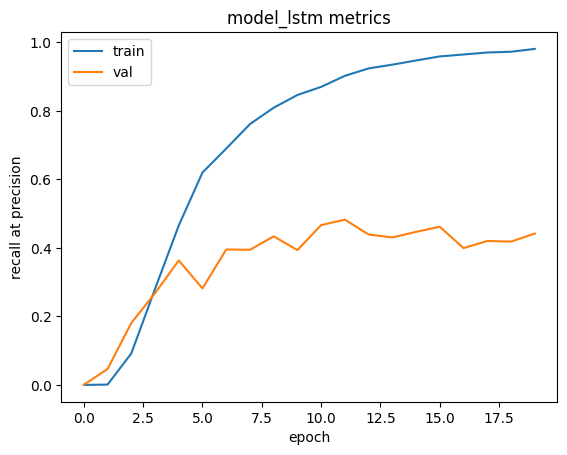

In [21]:
plt.plot(model_lstm.history.history['rec@prec'])
plt.plot(model_lstm.history.history['val_rec@prec'])
plt.title('model_lstm metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_lstm_pred = model_lstm.predict(X_valid)

70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step


In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
print(classification_report(np.argmax(y_lstm_pred, axis=-1),
                            np.argmax(y_valid, axis=-1),
                            target_names=list(id2label.values()),
                            labels=list(id2label.keys())))

                   precision    recall  f1-score   support

      Бывший СССР       0.62      0.58      0.60       171
            Спорт       0.93      0.93      0.93       194
         Ценности       0.35      0.32      0.33        25
              Дом       0.73      0.67      0.70        72
           Бизнес       0.18      0.33      0.24        12
        Экономика       0.76      0.75      0.76       240
   69-я параллель       0.00      0.00      0.00         0
              Мир       0.63      0.68      0.65       379
  Наука и техника       0.68      0.82      0.74       131
           Россия       0.69      0.58      0.63       577
         Культура       0.75      0.68      0.71       177
Силовые структуры       0.25      0.31      0.28        48
          Легпром       0.00      0.00      0.00         0
   Интернет и СМИ       0.36      0.42      0.39       115
    Культпросвет        0.00      0.00      0.00         0
         Из жизни       0.15      0.21      0.18       

2

In [25]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bi_lstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
bi_lstm2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bi_lstm1)

avg_pool = keras.layers.GlobalAveragePooling1D()(bi_lstm2)
max_pool = keras.layers.GlobalMaxPooling1D()(bi_lstm2)

concatenated = keras.layers.concatenate([bi_lstm2[:, -1], avg_pool, max_pool])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(concatenated)

model_bi_lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_bi_lstm.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [26]:
model_bi_lstm.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=20)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 2.5805 - rec@prec: 3.7644e-05 - val_loss: 2.0667 - val_rec@prec: 0.0000e+00
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 1.9414 - rec@prec: 6.1666e-04 - val_loss: 1.7803 - val_rec@prec: 0.0663
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 1.5773 - rec@prec: 0.0803 - val_loss: 1.4062 - val_rec@prec: 0.2723
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 1.1692 - rec@prec: 0.3957 - val_loss: 1.2916 - val_rec@prec: 0.3832
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.9330 - rec@prec: 0.5844 - val_loss: 1.2535 - val_rec@prec: 0.4292
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - loss: 0.7806 - rec@prec: 0.6980 - val_loss: 1.3399 - val_rec@prec: 0.4148
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.6854 - rec@prec: 0.7642 - val_loss: 1.2958 - val_rec@prec: 0.4995
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - loss: 0.5404 - rec@prec: 0.8569 - val_loss: 1.3464 - v

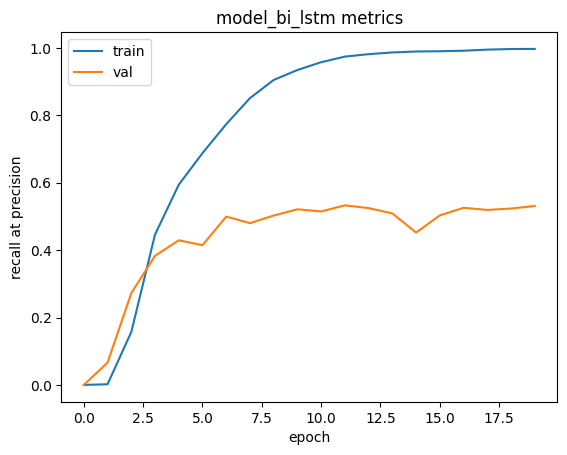

In [27]:
plt.plot(model_bi_lstm.history.history['rec@prec'])
plt.plot(model_bi_lstm.history.history['val_rec@prec'])
plt.title('model_bi_lstm metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
y_bi_lstm_pred = model_bi_lstm.predict(X_valid)

70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 543ms/step


In [29]:
print(classification_report(np.argmax(y_bi_lstm_pred, axis=-1),
                            np.argmax(y_valid, axis=-1),
                            target_names=list(id2label.values()),
                            labels=list(id2label.keys())))

                   precision    recall  f1-score   support

      Бывший СССР       0.65      0.60      0.62       174
            Спорт       0.91      0.92      0.91       192
         Ценности       0.52      0.67      0.59        18
              Дом       0.67      0.75      0.70        59
           Бизнес       0.23      0.21      0.22        24
        Экономика       0.66      0.80      0.72       197
   69-я параллель       0.00      0.00      0.00         5
              Мир       0.68      0.67      0.67       419
  Наука и техника       0.76      0.76      0.76       159
           Россия       0.70      0.65      0.67       512
         Культура       0.77      0.75      0.76       165
Силовые структуры       0.32      0.27      0.29        71
          Легпром       0.00      0.00      0.00         0
   Интернет и СМИ       0.45      0.45      0.45       132
    Культпросвет        0.00      0.00      0.00         1
         Из жизни       0.37      0.44      0.40       

##Задание 2

Подготовка

In [30]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [31]:
!pip install datasets #он не хотел устанавливать без изменения локали(((

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.0 MB/s eta 0:00:00


In [32]:
from datasets import load_dataset

In [33]:
dataset = load_dataset("tner/wikiann", 'ru')

README.md:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

wikiann.py:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


test.jsonl:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/2.63M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [34]:
data = dataset["train"]["tokens"]

In [35]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)
MAX_LEN = max(len(x) for x in X)

X_train = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

label2id = {
    "B-LOC": 0,
    "B-ORG": 1,
    "B-PER": 2,
    "I-LOC": 3,
    "I-ORG": 4,
    "I-PER": 5,
    "O": 6,
    "PAD": 7
}

id2labels = {v:k for k,v in label2id.items()}
y_train = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [36]:
X_train.shape, X_test.shape

((20000, 54), (10000, 54))

In [37]:
y_train.shape, y_test.shape

((20000, 54), (10000, 54))

Модели

1

In [38]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=128)(inputs)

lstm = keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru = keras.layers.GRU(128, return_sequences=True)(lstm)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru)

model_gru_lstm = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_gru_lstm.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [39]:
model_gru_lstm.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=500,
          epochs=20)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.7803 - loss: 0.9720 - val_accuracy: 0.8705 - val_loss: 0.2893
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.8885 - loss: 0.2734 - val_accuracy: 0.9323 - val_loss: 0.2354
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9336 - loss: 0.2253 - val_accuracy: 0.9384 - val_loss: 0.2084
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9404 - loss: 0.1958 - val_accuracy: 0.9417 - val_loss: 0.1898
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9444 - loss: 0.1725 - val_accuracy: 0.9470 - val_loss: 0.1696
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9552 - loss: 0.1447 - val_accuracy: 0.9581 - val_loss: 0.1420
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9675 - loss: 0.1037 - val_accuracy: 0.9603 - val_loss: 0.1221
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9760 - loss: 0.0703 - val_accuracy: 0.

In [40]:
model_gru_lstm.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 54)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 54, 128)             │       4,610,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 54, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 54, 128)             │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 54, 8)               │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,525,594 (55.41 MB)

 Trainable params: 4,841,864 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,683,730 (36.94 MB)

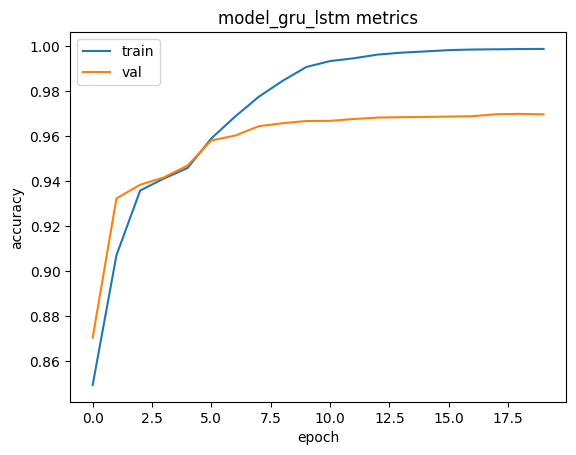

In [41]:
plt.plot(model_gru_lstm.history.history['accuracy'])
plt.plot(model_gru_lstm.history.history['val_accuracy'])
plt.title('model_gru_lstm metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
y_gru_lstm_pred = model_gru_lstm.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step


In [43]:
print(classification_report(np.argmax(y_gru_lstm_pred, axis=-1),
                            np.argmax(y_test, axis=-1),
                            target_names=list(id2labels.values()),
                            labels=list(id2labels.keys())))

              precision    recall  f1-score   support

       B-LOC       1.00      0.60      0.75         5
       B-ORG       0.00      0.00      0.00         2
       B-PER       0.00      0.00      0.00         3
       I-LOC       0.99      1.00      0.99       914
       I-ORG       1.00      0.99      0.99      1947
       I-PER       1.00      0.99      1.00      1933
           O       1.00      0.99      0.99      1529
         PAD       0.99      0.99      0.99       880

   micro avg       0.99      0.99      0.99      7213
   macro avg       0.75      0.70      0.71      7213
weighted avg       0.99      0.99      0.99      7213



2

In [44]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=128)(inputs)

lstm1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm2 = keras.layers.LSTM(128, return_sequences=True)(lstm1)
residual_connection1 = keras.layers.add([embeddings, lstm2])
lstm3 = keras.layers.LSTM(128, return_sequences=True)(residual_connection1)
residual_connection2 = keras.layers.add([embeddings, lstm3])
lstm4 = keras.layers.LSTM(128, return_sequences=True)(residual_connection2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm4)

model_resid_con = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_resid_con.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [45]:
model_resid_con.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=1000,
          epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 358ms/step - accuracy: 0.7235 - loss: 1.2483 - val_accuracy: 0.8680 - val_loss: 0.4012
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.8733 - loss: 0.3563 - val_accuracy: 0.8810 - val_loss: 0.3183
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 400ms/step - accuracy: 0.8929 - loss: 0.2975 - val_accuracy: 0.9085 - val_loss: 0.2699
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 391ms/step - accuracy: 0.9196 - loss: 0.2570 - val_accuracy: 0.9279 - val_loss: 0.2472
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 409ms/step - accuracy: 0.9332 - loss: 0.2292 - val_accuracy: 0.9345 - val_loss: 0.2284
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.9387 - loss: 0.2082 - val_accuracy: 0.9347 - val_loss: 0.2162
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 404ms/step - accuracy: 0.9412 - loss: 0.1902 - val_accuracy: 0.9381 - val_loss: 0.2048
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 0.9434 - loss: 0.1739 - val_accuracy: 0.

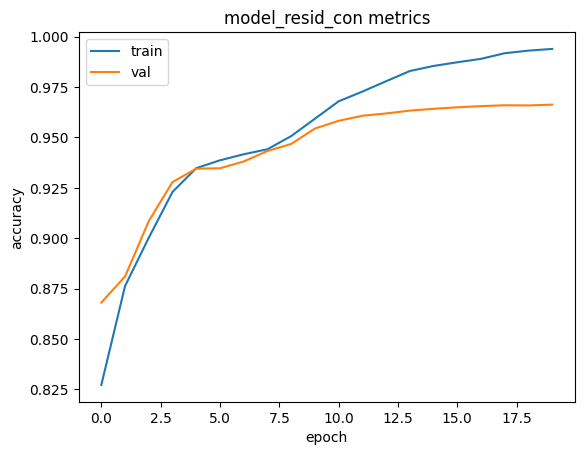

In [46]:
plt.plot(model_resid_con.history.history['accuracy'])
plt.plot(model_resid_con.history.history['val_accuracy'])
plt.title('model_resid_con metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
y_resid_con_pred = model_resid_con.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 48s 154ms/step


In [48]:
print(classification_report(np.argmax(y_resid_con_pred, axis=-1),
                            np.argmax(y_test, axis=-1),
                            target_names=list(id2labels.values()),
                            labels=list(id2labels.keys())))

              precision    recall  f1-score   support

       B-LOC       1.00      0.05      0.10        55
       B-ORG       0.00      0.00      0.00        14
       B-PER       0.00      0.00      0.00        11
       I-LOC       0.88      0.97      0.92       841
       I-ORG       0.92      0.92      0.92      1946
       I-PER       0.96      0.92      0.94      2010
           O       0.96      0.95      0.95      1546
         PAD       0.93      0.94      0.93       867

   micro avg       0.94      0.92      0.93      7290
   macro avg       0.71      0.59      0.60      7290
weighted avg       0.93      0.92      0.92      7290



3

In [49]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bilstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
conv1 = keras.layers.Conv1D(kernel_size=5, filters=256, padding="same", strides=1)(bilstm1)
bilstm2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(conv1)
conv2 = keras.layers.Conv1D(kernel_size=5, filters=256, padding="same", strides=1)(bilstm2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(conv2)

model_rnn_cnn = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_rnn_cnn.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

In [50]:
model_rnn_cnn.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          batch_size=1000,
          epochs=20)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - accuracy: 0.8427 - loss: 0.9214 - val_accuracy: 0.9228 - val_loss: 0.2650
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 462ms/step - accuracy: 0.9270 - loss: 0.2457 - val_accuracy: 0.9370 - val_loss: 0.1916
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 450ms/step - accuracy: 0.9390 - loss: 0.1881 - val_accuracy: 0.9486 - val_loss: 0.1648
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.9504 - loss: 0.1589 - val_accuracy: 0.9541 - val_loss: 0.1439
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 432ms/step - accuracy: 0.9581 - loss: 0.1317 - val_accuracy: 0.9586 - val_loss: 0.1278
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 453ms/step - accuracy: 0.9632 - loss: 0.1123 - val_accuracy: 0.9597 - val_loss: 0.1212
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 452ms/step - accuracy: 0.9663 - loss: 0.0978 - val_accuracy: 0.9614 - val_loss: 0.1181
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 455ms/step - accuracy: 0.9707 - loss: 0.0833 - val_accuracy: 0

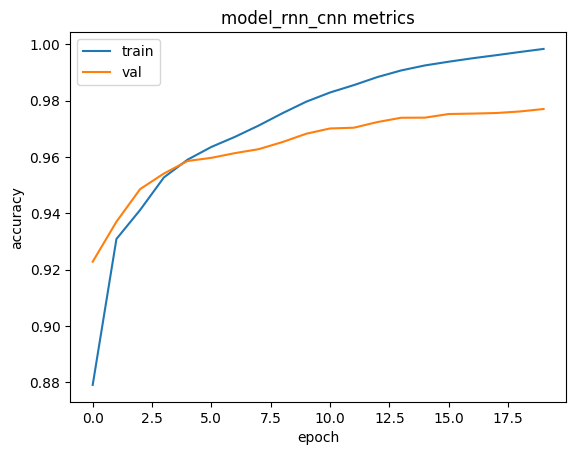

In [51]:
plt.plot(model_rnn_cnn.history.history['accuracy'])
plt.plot(model_rnn_cnn.history.history['val_accuracy'])
plt.title('model_rnn_cnn metrics')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [52]:
y_rnn_cnn_pred = model_rnn_cnn.predict(X_test).argmax(2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 161ms/step


In [53]:
print(classification_report(np.argmax(y_rnn_cnn_pred, axis=-1),
                            np.argmax(y_test, axis=-1),
                            target_names=list(id2labels.values()),
                            labels=list(id2labels.keys())))

              precision    recall  f1-score   support

       B-LOC       1.00      1.00      1.00         3
       B-ORG       0.00      0.00      0.00         0
       B-PER       0.00      0.00      0.00        22
       I-LOC       0.97      0.92      0.95       972
       I-ORG       0.96      0.97      0.96      1911
       I-PER       0.97      0.99      0.98      1898
           O       0.99      0.98      0.99      1533
         PAD       0.97      0.98      0.98       865

   micro avg       0.97      0.97      0.97      7204
   macro avg       0.73      0.73      0.73      7204
weighted avg       0.97      0.97      0.97      7204



Inference

In [54]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [55]:
label_seq('Алексей сказал Михалычу, чтобы он собирался на поезд в Москву.', word2id, id2labels, MAX_LEN, model_gru_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Михалычу', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('он', 'O'),
 ('собирался', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [56]:
label_seq('Алексей сказал Михалычу, чтобы он собирался на поезд в Москву.', word2id, id2labels, MAX_LEN, model_resid_con)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Михалычу', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('он', 'O'),
 ('собирался', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [57]:
label_seq('Алексей сказал Михалычу, чтобы он собирался на поезд в Москву.', word2id, id2labels, MAX_LEN, model_rnn_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


[('Алексей', 'B-PER'),
 ('сказал', 'I-PER'),
 ('Михалычу', 'I-PER'),
 (',', 'O'),
 ('чтобы', 'O'),
 ('он', 'O'),
 ('собирался', 'O'),
 ('на', 'O'),
 ('поезд', 'O'),
 ('в', 'O'),
 ('Москву', 'B-LOC'),
 ('.', 'O')]

In [58]:
label_seq('Ехал Грека через реку, видит — в реке рак.', word2id, id2labels, MAX_LEN, model_gru_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


[('Ехал', 'O'),
 ('Грека', 'O'),
 ('через', 'O'),
 ('реку', 'O'),
 (',', 'O'),
 ('видит', 'O'),
 ('—', 'O'),
 ('в', 'O'),
 ('реке', 'O'),
 ('рак', 'B-LOC'),
 ('.', 'O')]

In [59]:
label_seq('Ехал Грека через реку, видит — в реке рак.', word2id, id2labels, MAX_LEN, model_resid_con)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


[('Ехал', 'I-PER'),
 ('Грека', 'I-PER'),
 ('через', 'O'),
 ('реку', 'O'),
 (',', 'O'),
 ('видит', 'O'),
 ('—', 'O'),
 ('в', 'O'),
 ('реке', 'O'),
 ('рак', 'O'),
 ('.', 'O')]

In [60]:
label_seq('Ехал Грека через реку, видит — в реке рак.', word2id, id2labels, MAX_LEN, model_rnn_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


[('Ехал', 'B-ORG'),
 ('Грека', 'O'),
 ('через', 'O'),
 ('реку', 'O'),
 (',', 'O'),
 ('видит', 'O'),
 ('—', 'O'),
 ('в', 'O'),
 ('реке', 'B-LOC'),
 ('рак', 'B-LOC'),
 ('.', 'O')]

In [61]:
label_seq('Тренер Нурмагомедова рассказал, за счет чего Анкалаев стал чемпионом UFC.', word2id, id2labels, MAX_LEN, model_gru_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


[('Тренер', 'O'),
 ('Нурмагомедова', 'B-ORG'),
 ('рассказал', 'I-ORG'),
 (',', 'O'),
 ('за', 'O'),
 ('счет', 'O'),
 ('чего', 'O'),
 ('Анкалаев', 'O'),
 ('стал', 'O'),
 ('чемпионом', 'O'),
 ('UFC', 'B-ORG'),
 ('.', 'O')]

In [62]:
label_seq('Тренер Нурмагомедова рассказал, за счет чего Анкалаев стал чемпионом UFC.', word2id, id2labels, MAX_LEN, model_resid_con)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


[('Тренер', 'O'),
 ('Нурмагомедова', 'B-ORG'),
 ('рассказал', 'I-ORG'),
 (',', 'O'),
 ('за', 'O'),
 ('счет', 'O'),
 ('чего', 'O'),
 ('Анкалаев', 'O'),
 ('стал', 'O'),
 ('чемпионом', 'O'),
 ('UFC', 'O'),
 ('.', 'O')]

In [63]:
label_seq('Тренер Нурмагомедова рассказал, за счет чего Анкалаев стал чемпионом UFC.', word2id, id2labels, MAX_LEN, model_rnn_cnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


[('Тренер', 'O'),
 ('Нурмагомедова', 'B-PER'),
 ('рассказал', 'I-PER'),
 (',', 'O'),
 ('за', 'O'),
 ('счет', 'B-ORG'),
 ('чего', 'O'),
 ('Анкалаев', 'O'),
 ('стал', 'O'),
 ('чемпионом', 'O'),
 ('UFC', 'B-ORG'),
 ('.', 'O')]

Результаты

С простыми примерами все 3 модели хорошо отработали.
С примерами посложнее есть следующие проблемы: в 3 примере все модели разметили глагол как I-ORG, не разметили имя собственное - фамилию Анкалаев, во 2 примере модели model_gru_lstm и model_rnn_cnn неправильно проставили теги B-LOC для последнего слова, однако правильно поставили для "реки", model_resid_con вообще не реагирует на LOC. Лучшие результаты показала модель model_rnn_cnn: понимает значение LOC, отличает PER и ORG, хоть и не идеально.